In [ ]:
import pandas as pd
import asyncio
from typing import List
import ollama
import numpy as np

## Embedding Resumes

In [ ]:
resume_path = '/Users/thubpham/Downloads/archive (1) 2/Resume/Resume.csv'
df = pd.read_csv(resume_path)

In [ ]:
async def get_embeddings(text: str, model: str = "dengcao/Qwen3-Embedding-0.6B:Q8_0") -> List[float]:
    response = await ollama.AsyncClient().embeddings(
        model=model,
        prompt=str(text)
    )
    return response.embedding

In [ ]:
async def embed_resumes(
    df: pd.DataFrame,
    text_column: str,
    embedding_column: str = "embeddings", # Is this fixing that the column must be named embeddings?
    model: str = "dengcao/Qwen3-Embedding-0.6B:Q8_0",
    batch_size: int = 100 # Reducing batch size
) -> pd.DataFrame:

    result_df = df.copy()
    embeddings = []
    total_rows = len(result_df)
    print(f"Processing {total_rows} rows in batches of {batch_size} with Ollama model '{model}'.")

    # Start batch-processing
    for i in range (0, total_rows, batch_size):
        batch_end = min(i + batch_size, total_rows)
        batch = df[text_column].iloc[i:batch_end] # Remove text_column with the name of your text column 

        tasks = [get_embeddings(text, model) for text in batch]
        try:
            batch_embeddings = await asyncio.gather(*tasks, return_exceptions=True)
            processed_embeddings = []
            # for emb in batch_embeddings:
            #     if isinstance(emb, Exception):
            #         print(f"Error in embedding: {emb.__class__.__name__} - {emb}")
            #         processed_embeddings.append([0.0] * 768)  # Default embedding size
            #     else:
            #         processed_embeddings.append(emb)
            
            # Add row_number to catch which row has error
            for idx_in_batch, emb in enumerate(batch_embeddings):
                row_number = i + idx_in_batch
                if isinstance(emb, Exception):
                    print(f"Error in embedding row {row_number}: {emb.__class__.__name__} - {emb}")
                    processed_embeddings.append([0.0] * 768)  # Default embedding size
                else:
                    processed_embeddings.append(emb)
            embeddings.extend(processed_embeddings)
        except Exception as e:
            print(f"Error processing batch {i} to {batch_end}: {e.__class__.__name__} - {e}")
            embeddings.extend([[0.0] * 768] * (batch_end - i))  # Default embedding size for failed batch

        print(f"Processed rows {batch_end} / {total_rows} rows")
        await asyncio.sleep(0.5)  # Small delay to avoid overwhelming the API
    
    result_df[embedding_column] = embeddings
    return result_df

In [ ]:
async def main():
    df_with_embeddings = await embed_resumes(
        df=df,
        text_column='Resume_str',
        embedding_column='embeddings',
        model='dengcao/Qwen3-Embedding-0.6B:Q8_0'
    )
    return df_with_embeddings 

In [ ]:
import nest_asyncio
nest_asyncio.apply()

In [ ]:
df_result = await main()

In [ ]:
df_result.to_csv("resume_embeddings.csv", encoding="utf-8")

## Embedding Jobs

In [ ]:
job_description = """
Minimum qualifications:
Bachelor’s degree or equivalent practical experience.
2 years of experience with software development in C++ and Python or 1 year of experience with an advanced degree.
1 year of experience with Machine Leaning (ML) infrastructure (e.g., model deployment, model evaluation, optimization, data processing, debugging).
1 year of experience with one of the following Artificial Intelligence/Machine Learning (AI/ML) techniques: Generative AI, Computer Vision, Natural Language Processing (NLP), information retrieval, or a related ML field.

Preferred qualifications:
Master's degree or PhD in Computer Science or a related technical field.
2 years of experience with data structures or algorithms.
Experience in Deep Learning, Neural Networks, or a related field.
Experience with statistical data analysis.
Knowledge of Unix/Linux environments.
About the job
Google's software engineers develop the next-generation technologies that change how billions of users connect, explore, and interact with information and one another. Our products need to handle information at massive scale, and extend well beyond web search. We're looking for engineers who bring fresh ideas from all areas, including information retrieval, distributed computing, large-scale system design, networking and data storage, security, artificial intelligence, natural language processing, UI design and mobile; the list goes on and is growing every day. As a software engineer, you will work on a specific project critical to Google’s needs with opportunities to switch teams and projects as you and our fast-paced business grow and evolve. We need our engineers to be versatile, display leadership qualities and be enthusiastic to take on new problems across the full-stack as we continue to push technology forward. Google Ads is helping power the open internet with the best technology that connects and creates value for people, publishers, advertisers, and Google. We’re made up of multiple teams, building Google’s Advertising products including search, display, shopping, travel and video advertising, as well as analytics. Our teams create trusted experiences between people and businesses with useful ads. We help grow businesses of all sizes from small businesses, to large brands, to YouTube creators, with effective advertiser tools that deliver measurable results. We also enable Google to engage with customers at scale.

The US base salary range for this full-time position is $141,000-$202,000 + bonus + equity + benefits. Our salary ranges are determined by role, level, and location. Within the range, individual pay is determined by work location and additional factors, including job-related skills, experience, and relevant education or training. Your recruiter can share more about the specific salary range for your preferred location during the hiring process.

Please note that the compensation details listed in US role postings reflect the base salary only, and do not include bonus, equity, or benefits. Learn more about benefits at Google.
Responsibilities
Write product or system development code.
Collaborate with peers and stakeholders through design and code reviews to ensure best practices among available technologies (e.g., style guidelines, checking code in, accuracy, testability and efficiency).
Contribute to existing documentation or educational content and adapt content based on product/program updates and user feedback.
Triage product or system issues and debug/track/resolve by analyzing the sources of issues and the impact on hardware, network, or service operations and quality.
Implement solutions in one or more specialized Machine Learning (ML) areas, utilize ML infrastructure, and contribute to model optimization and data processing.
"""

In [ ]:
job_embedding = await get_embeddings(job_description)

## Calculate Cosine Similarity

In [ ]:
import ast

In [ ]:
df_resume_embeddings = pd.read_csv("/Users/thubpham/Desktop/ai4all/resume_embeddings.csv")
df_resume_embeddings.head()

In [ ]:
# Convert from stringifiled list back to list

df_resume_embeddings['embeddings'] = df_resume_embeddings['embeddings'].apply(ast.literal_eval)
df_resume_embeddings['embeddings'].apply(type)

In [ ]:
def calculate_cosine_similarity(
    df: pd.DataFrame,
    job_embedding: list,
) -> pd.DataFrame:
    try: 

        if job_embedding is None or len(job_embedding) == 0:
            print("Job embedding is None or empty.")
            return df
        if df is None or df.empty:
            print("DataFrame is None or empty.")
            return df
        
        # Converting job_embedding to numoy array for calculation
        job_embedding_array = np.array(job_embedding, dtype=np.float32)
        job_norm = np.linalg.norm(job_embedding_array)
        if job_norm == 0:
            print("Job embedding norm is zero.")
            return df
        
        df_with_score = df.copy()
        score = []

        for idx, resume_embedding in enumerate(df_with_score['embeddings']):
            try: 
                # Handles None or emty resume_embedding
                if resume_embedding is None or len(resume_embedding) == 0:
                    print(f"Resume row {i} embedding is None or empty. Assigning score of 0.")
                    score.append(0.0)
                    continue

                # Converting resume_embedding to numpy array for calculation
                resume_embedding_array = np.array(resume_embedding, dtype=np.float32)
                resume_norm = np.linalg.norm(resume_embedding_array)
                if resume_norm == 0:
                    print(f"Resume row {idx} embedding norm is zero. Assigning score of 0.")
                    score.append(0.0)
                    continue

                # Calculate cosine similarity
                cosine_similarity = float(np.dot(job_embedding_array, resume_embedding_array) / (job_norm * resume_norm))
                score.append(cosine_similarity)

            except Exception as e:
                print(f"Error calculating cosine similarity for a resume embedding: {e.__class__.__name__} - {e}. Assigning score of 0.")
                score.append(0.0)

        df_with_score['scores'] = score 
        return df_with_score
    
    except Exception as e:
        print(f"Error in calculate_cosine_similarity: {e.__class__.__name__} - {e}")
        return df

In [ ]:
df_result_with_scores = calculate_cosine_similarity(
    df=df_resume_embeddings,
    job_embedding=job_embedding
)

print(df_result_with_scores.head())

In [ ]:
df_result_with_scores.to_csv("resume_embeddings_with_scores.csv", encoding="utf-8")

## Scoring

### Scored Delta

In [ ]:

paired = df.pivot(index='pair_id', columns='variant_label', values='score') 

# Calculate delta 
paired['delta'] = paired['mut'] - paired['base']

# Calculate statistics 
mean_delta = paired['delta'].mean()
sd_delta = paired['delta'].std(ddof=1)
t_stat, p_value = stats.ttest_rel(paired['mut'], paired['base'])

### SHAP

Implementation for: Surrogate model + SHAP explanation of cosine similarity scores

Flow:
1. Loads a CSV or dataframe that contains: resume_id, resume_text, cosine_score (computed against job embedding)
2. Extracts interpretable features from resume_text (heuristics + customizable placeholders).
3. Trains a surrogate regressor to predict cosine_score from features.
4. Runs SHAP KernelExplainer and creates plots and summary metrics for fairness.

Notes:
- Customize feature extraction to fit your dataset (this uses simple heuristics as examples).
- KernelExplainer can be slow for large feature sets / many samples. Use a representative "background" sample.
- Replace dummy lists (TOP_SCHOOLS, TECH_WORDS) with your curated lists or lookup tables.

Dependencies: pandas, numpy, scikit-learn, xgboost, shap, matplotlib

In [ ]:
import matplotlib.pyplot as plt
import shap
import xgboost as xgb
import re
import json
import math

# Imports for scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
import gender_guesser.detector as gender
import ethnicolr
import spacy

In [ ]:
resume_texts = df['Resume_str'].tolist()
# print(resume_texts[0])

#### Dictionary

In [ ]:
# ------------------------------
# INITIALIZE DETECTORS AND LISTS
# ------------------------------

# Initialize Gender Detector once (it loads a large dataset)
gender_detector = gender.Detector()

# To get this exhaustively: Scrape US News "Best Global Universities" or Wikipedia "List of research universities"
SCHOOL_TIERS = {
    # --- TIER 1: National Universities (Top 50) ---
    "princeton university": 1,
    "massachusetts institute of technology": 1,
    "harvard university": 1,
    "stanford university": 1,
    "yale university": 1,
    "california institute of technology": 1,
    "duke university": 1,
    "johns hopkins university": 1,
    "northwestern university": 1,
    "university of pennsylvania": 1,
    "cornell university": 1,
    "university of chicago": 1,
    "brown university": 1,
    "columbia university": 1,
    "dartmouth college": 1,
    "university of california, los angeles": 1,
    "university of california, berkeley": 1,
    "rice university": 1,
    "university of notre dame": 1,
    "vanderbilt university": 1,
    "carnegie mellon university": 1,
    "university of michigan, ann arbor": 1,
    "washington university in st. louis": 1,
    "emory university": 1,
    "georgetown university": 1,
    "university of virginia": 1,
    "university of north carolina at chapel hill": 1,
    "university of southern california": 1,
    "university of california, san diego": 1,
    "university of california, davis": 1,
    "university of florida": 1,
    "university of texas at austin": 1,
    "georgia institute of technology": 1,
    "university of california, irvine": 1,
    "university of illinois urbana-champaign": 1,
    "university of wisconsin—madison": 1,
    "boston college": 1,
    "tufts university": 1,
    "new york university": 1,
    "boston university": 1,
    "university of california, santa barbara": 1,
    "rutgers university—new brunswick": 1,
    "purdue university": 1,
    "university of washington": 1,
    "ohio state university": 1,
    "university of maryland, college park": 1,
    "lehigh university": 1,
    "university of rochester": 1,
    "wake forest university": 1,

    # --- TIER 1: Liberal Arts Colleges (Top ~50) ---
    "williams college": 1,
    "amherst college": 1,
    "swarthmore college": 1,
    "united states naval academy": 1,
    "pomona college": 1,
    "bowdoin college": 1,
    "wellesley college": 1,
    "claremont mckenna college": 1,
    "united states air force academy": 1,
    "united states military academy": 1,
    "carleton college": 1,
    "davidson college": 1,
    "grinnell college": 1,
    "hamilton college": 1,
    "harvey mudd college": 1,
    "middlebury college": 1,
    "smith college": 1,
    "vassar college": 1,
    "wesleyan university": 1,
    "washington and lee university": 1,
    "barnard college": 1,
    "colgate university": 1,
    "haverford college": 1,
    "university of richmond": 1,
    "bates college": 1,
    "colby college": 1,
    "macalester college": 1,
    "holy cross college": 1,
    "bryn mawr college": 1,
    "bucknell university": 1,
    "mount holyoke college": 1,
    "scripps college": 1,
    "skidmore college": 1,
    "pitzer college": 1,
    "lafayette college": 1,
    "colorado college": 1,
    "oberlin college": 1,
    "kenyon college": 1,
    "franklin & marshall college": 1,

    # --- TIER 2: National Universities (Rank 51-200) ---
    "case western reserve university": 2,
    "texas a&m university": 2,
    "virginia tech": 2,
    "florida state university": 2,
    "northeastern university": 2,
    "university of minnesota, twin cities": 2,
    "william & mary": 2,
    "north carolina state university": 2,
    "stony brook university—suny": 2,
    "university of california, merced": 2,
    "university of massachusetts amherst": 2,
    "villanova university": 2,
    "brandeis university": 2,
    "george washington university": 2,
    "michigan state university": 2,
    "pennsylvania state university": 2,
    "university of connecticut": 2,
    "university of georgia": 2,
    "university of pittsburgh": 2,
    "syracuse university": 2,
    "clemson university": 2,
    "pepperdine university": 2,
    "rensselaer polytechnic institute": 2,
    "santa clara university": 2,
    "tulane university": 2,
    "university of miami": 2,
    "binghamton university—suny": 2,
    "indiana university bloomington": 2,
    "worcester polytechnic institute": 2,
    "southern methodist university": 2,
    "university at buffalo—suny": 2,
    "university of delaware": 2,
    "university of iowa": 2,
    "american university": 2,
    "baylor university": 2,
    "gonzaga university": 2,
    "loyola marymount university": 2,
    "marquette university": 2,
    "stevens institute of technology": 2,
    "texas christian university": 2,
    "university of arizona": 2,
    "university of california, riverside": 2,
    "university of california, santa cruz": 2,
    "university of illinois chicago": 2,
    "university of tennessee, knoxville": 2,
    "auburn university": 2,
    "brigham young university": 2,
    "colorado school of mines": 2,
    "drexel university": 2,
    "florida international university": 2,
    "new jersey institute of technology": 2,
    "temple university": 2,
    "university of colorado boulder": 2,
    "university of oregon": 2,
    "university of san diego": 2,
    "university of south florida": 2,
    "university of utah": 2,
    "yeshiva university": 2,
    "arizona state university": 2,
    "iowa state university": 2,
    "rochester institute of technology": 2,
    "university of central florida": 2,
    "university of kentucky": 2,
    "university of oklahoma": 2,
    "university of san francisco": 2,
    "university of south carolina": 2,
    "george mason university": 2,
    "rutgers university—newark": 2,
    "seattle university": 2,
    "seton hall university": 2,
    "university of alabama": 2,
    "university of arkansas": 2,
    "university of cincinnati": 2,
    "university of kansas": 2,
    "university of mississippi": 2,
    "university of missouri": 2,
    "university of texas at dallas": 2,
    "clark university": 2,
    "depaul university": 2,
    "duquesne university": 2,
    "elon university": 2,
    "fairfield university": 2,
    "howard university": 2,
    "illinois institute of technology": 2,
    "miami university—oxford": 2,
    "michigan technological university": 2,
    "quinnipiac university": 2,
    "saint louis university": 2,
    "san diego state university": 2,
    "university of dayton": 2,
    "university of denver": 2,
    "university of maryland, baltimore county": 2,
    "university of nebraska—lincoln": 2,
    "university of new hampshire": 2,
    "university of the pacific": 2,
    "university of tulsa": 2,
    "university of vermont": 2,
    
    # --- TIER 2: Liberal Arts Colleges (Select Examples) ---
    "connecticut college": 2,
    "denison university": 2,
    "dickinson college": 2,
    "furman university": 2,
    "gettysburg college": 2,
    "rhodes college": 2,
    "sewanee: the university of the south": 2,
    "trinity college": 2,
    "union college": 2,
    "whitman college": 2,
    "occidental college": 2,
    "centre college": 2,
    "bard college": 2,
    "spelman college": 2,
    "hobart and william smith colleges": 2,
    "st. olaf college": 2,
    "thomas aquinas college": 2
}

# Women's Colleges (Historical & Current)
# WOMENS_COLLEGES = {
#     "wellesley", "smith college", "barnard", "bryn mawr", "mount holyoke", 
#     "scripps", "spelman", "agness scott", "mills college", "sweet briar"
# }

# Needs expansion: Tech Stack (Modern & Legacy)
TECH_WORDS = {
    "python", "java", "c++", "c#", "javascript", "typescript", "react", "angular", "vue",
    "sql", "nosql", "mongodb", "postgres", "mysql",
    "tensorflow", "pytorch", "keras", "scikit-learn", "pandas", "numpy",
    "aws", "azure", "gcp", "docker", "kubernetes", "jenkins", "git"
}

US_STATES = {
    "alabama": "AL", "alaska": "AK", "arizona": "AZ", "arkansas": "AR",
    "california": "CA", "colorado": "CO", "connecticut": "CT", "delaware": "DE",
    "florida": "FL", "georgia": "GA", "hawaii": "HI", "idaho": "ID",
    "illinois": "IL", "indiana": "IN", "iowa": "IA", "kansas": "KS",
    "kentucky": "KY", "louisiana": "LA", "maine": "ME", "maryland": "MD",
    "massachusetts": "MA", "michigan": "MI", "minnesota": "MN",
    "mississippi": "MS", "missouri": "MO", "montana": "MT", "nebraska": "NE",
    "nevada": "NV", "new hampshire": "NH", "new jersey": "NJ",
    "new mexico": "NM", "new york": "NY", "north carolina": "NC",
    "north dakota": "ND", "ohio": "OH", "oklahoma": "OK",
    "oregon": "OR", "pennsylvania": "PA", "rhode island": "RI",
    "south carolina": "SC", "south dakota": "SD", "tennessee": "TN",
    "texas": "TX", "utah": "UT", "vermont": "VT", "virginia": "VA",
    "washington": "WA", "west virginia": "WV", "wisconsin": "WI",
    "wyoming": "WY"
}

# Mapping by major city guarantees the right state abbreviation
MAJOR_US_CITIES = {
    "san francisco": "CA", "sf": "CA",
    "los angeles": "CA", "la": "CA",
    "san jose": "CA", "sj": "CA",
    "san diego": "CA",
    "seattle": "WA",
    "new york city": "NY", "nyc": "NY",
    "boston": "MA",
    "chicago": "IL",
    "austin": "TX",
    "houston": "TX",
    "dallas": "TX",
    "atlanta": "GA",
    "miami": "FL",
    "philadelphia": "PA",
    "washington dc": "DC", "dc": "DC",
}

BIG_STATES = [
    "CA", "WA", "NY", "MA", "IL", "TX", "GA", "FL", "PA", "DC",
]

#### Features Extraction

In [ ]:
# ---------------------------------------------------------
# FEATURE EXTRACTION
# ---------------------------------------------------------

def extract_comprehensive_features(resume_text: str) -> dict:
    
    if not isinstance(resume_text, str):
        resume_text = ''
    
    txt_raw = resume_text # Keep original case for Name detection, lower for everything else
    txt = resume_text.lower()
    tokens = re.findall(r"[a-z0-9+#.+-]+", txt)
    token_count = len(tokens)
    unique_tokens = len(set(tokens)) # A set of token to eliminates duplicates
    
    # ---------------------------------
    # A. CONTROLS VARIABLES (Productivity)
    # ---------------------------------
    
    # Tech Skills (Control)
    tech_count = sum(1 for t in TECH_WORDS if t in txt)

    # Experience Years (Control)
    # Looks for "X years" or "X+ years"
    years_exp = 0
    m = re.search(r"(\d{1,2})\s*\+?\s*years?", txt)
    if m:
        try:
            years_exp = int(m.group(1))
        except:
            pass

    # ---------------------------------
    # B. GENDER BIAS FEATURES
    # ---------------------------------
    
    # Encode Gender for SHAP (One-Hot or Probability Proxy)

    # gender_prediction = gender_detector.get_gender(first_name_guess)

    # # gender_guesser returns: male, female, mostly_male, mostly_female, unknown, andy (androgynous)
    # is_female_prob = 1.0 if 'female' in gender_prediction else (0.5 if gender_prediction == 'andy' else 0.0)
    # is_male_prob = 1.0 if 'male' in gender_prediction else (0.5 if gender_prediction == 'andy' else 0.0)

    # # 2. Pronoun Usage
    # # Counts she/her vs he/him
    # she_count = len(re.findall(r"\b(she|her|hers)\b", txt))
    # he_count = len(re.findall(r"\b(he|him|his)\b", txt))
    # pronoun_bias = "female" if she_count > he_count else ("male" if he_count > she_count else "neutral")
    
    # # 3. Women's Colleges
    # has_womens_college = 1 if any(c in txt for c in WOMENS_COLLEGES) else 0

    # ---------------------------------
    # C. RACIAL & LOCATION BIAS
    # ---------------------------------

    # Enhanced location detection

    us_state = ""

    # Search by major cities
    for city, state_abbr in MAJOR_US_CITIES.items():
        if re.search(rf"\b{re.escape(city)}\b", txt):
            us_state = state_abbr

    # Search by full state names
    for state_name, abbr in US_STATES.items():
        if re.search(rf"\b{re.escape(state_name)}\b", txt):
            us_state = abbr
    
    # Check if applicant is in US or not
    if us_state == "":
        is_us_location = 0
    else:
        is_us_location = 1
    
    # 2. Ethnicity Proxy (Prep)
    # We return the 'first_name_guess' so you can run 'ethnicolr' on the dataframe later.
    # Running deep learning models inside this loop is too slow.
    
    # ---------------------------------
    # D. PRESTIGE BIAS
    # ---------------------------------
    
    for s in SCHOOL_TIERS.keys():
        if s in txt: 
            school_tier = SCHOOL_TIERS[s]
            break
        else:
            school_tier = 0

    return {
        # Controls
        'tech_count': tech_count,
        'years_experience': years_exp,
        'token_count': token_count,

        # Bias: Gender
        # 'name_guessed': first_name_guess, # Wrong, not catching name lmao
        # 'gender_prob_female': is_female_prob,
        # 'gender_prob_male': is_male_prob,
        # 'pronoun_count_female': she_count,
        # 'pronoun_count_male': he_count,
        # 'attended_womens_college': has_womens_college,

        # Bias: Race/Location
        'is_us_location': is_us_location,
        'us_state': us_state,
        
        # Bias: Prestige
        'school_tier': school_tier,
    }

In [ ]:
df_features = pd.DataFrame([extract_comprehensive_features(t) for t in resume_texts])

In [ ]:
df_features.head()

In [ ]:
unique_school_tiers = df_features['school_tier'].value_counts()
unique_school_tiers

In [ ]:
# State encoding

for state in BIG_STATES:
    df_features[state] = df_features['us_state'].apply(lambda x: 1 if x == state else 0)
df_features['other'] = df_features['us_state'].apply(lambda x: 1 if x not in BIG_STATES else 0)

In [ ]:
df_features.to_csv("final_df_w_features.csv", encoding="utf-8")

#### Merging features with cosine similarity scores

In [ ]:
df_features = pd.read_csv("final_df_w_features.csv")
df_features.head()

In [ ]:
df_result_with_scores = pd.read_csv("/Users/thubpham/Desktop/ai4all/resume_embeddings_with_scores.csv")
df_result_with_scores.head()

In [ ]:
df_merged = pd.concat([df_result_with_scores.reset_index(drop=True), df_features.reset_index(drop=True)], axis=1)
df_merged.head()

In [ ]:
df_merged.columns

In [ ]:
df_merged = df_merged.drop(columns=['Unnamed: 0'], axis=1)
df_merged.head()

In [ ]:
# Save final dataframe with all features
df_merged.to_csv("final_df_w_all_features.csv", encoding="utf-8")

#### Training Models

##### Ridge Regression

In [ ]:
final_df = pd.read_csv("/Users/thubpham/Desktop/ai4all/final_df_w_all_features.csv")
final_df = final_df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'], axis=1)
final_df.head()

In [37]:
# Preparing X and y for model training

y = final_df['scores']
X = final_df.drop(columns=['scores', 'Resume_str', 'Resume_html', 'Category', 'embeddings', 'ID', 'us_state'], axis=1)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error, r2_score

In [38]:
# Split the dataset into training and testing sets
# Why test_size = 0.2 and random_state = 42 though?

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [39]:
ridge = Ridge(alpha=1.0) # alpha is the regularization strength
ridge.fit(X_train, y_train)

,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [40]:
# Predict on the test set
y_pred = ridge.predict(X_test)

In [41]:
# Evaluation
print("RMSE:", root_mean_squared_error(y_test, y_pred))
print("R^2:", r2_score(y_test, y_pred))

RMSE: 0.05362614945433461
R^2: 0.21993801938743862


In [ ]:
import joblib

In [42]:
# Save model to be used later
joblib.dump(ridge, 'ridge_model.pkl')

['ridge_model.pkl']

#### SHAP

In [ ]:
import shap

In [43]:
# Create a SHAP explainer for the model

explainer = shap.Explainer(ridge, X_train)
shap_values = explainer(X_test)

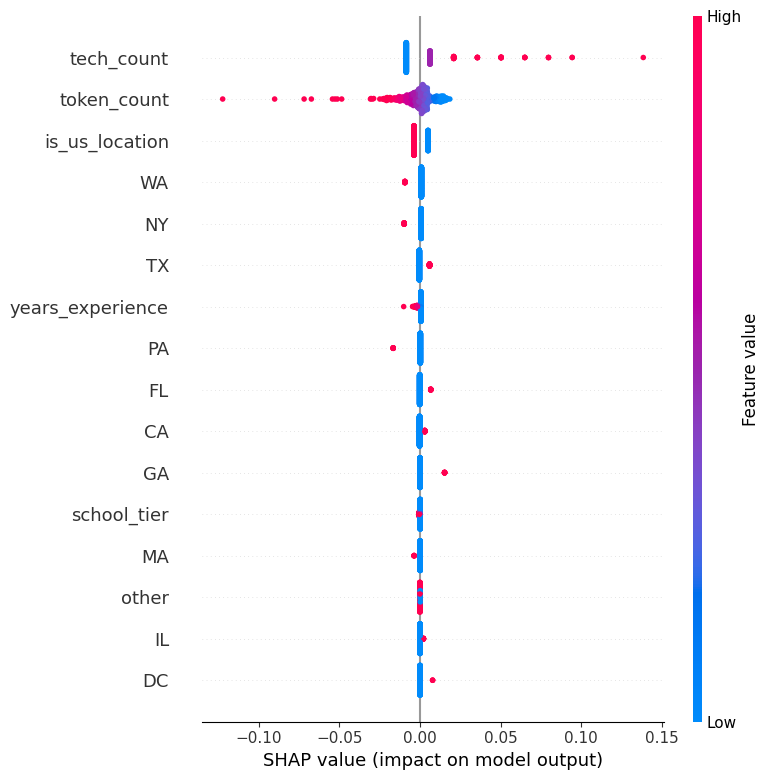

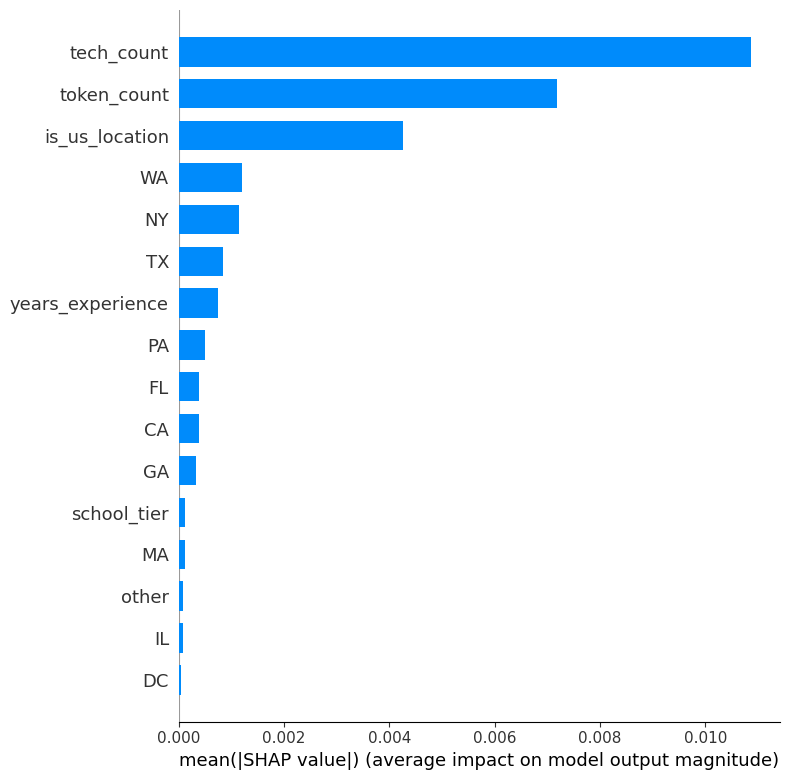

In [44]:
# Plot
shap.summary_plot(shap_values, X_test) # Beeswarm plot by default
shap.summary_plot(shap_values, X_test, plot_type="bar") # Bar plot

#### Name Detection (Not Used)

In [ ]:
# Name extraction using Spacy

nlp = spacy.load("en_core_web_sm", disable=["parser", "tagger", "lemmatizer"]) # en_core_web_sm is a spacy model
# resume_chunked = [resume[:1000] for resume in resume_texts] # Limit to first 500 characters to save time
first_name_guess = []

for doc in nlp.pipe(resume_texts, batch_size=50):
    
    person_entities = [ent.text for ent in doc.ents if ent.label == "PERSON"] # Reset person_entities list for each person

    # Assume the first name in the list is a person
    if person_entities: 
        first_name_guess.append(person_entities[0].split()[0])
    else: 
        first_name_guess.append("")

df_features['name_guessed'] = first_name_guess

In [ ]:
df_features.head()
empty_names = df_features[df_features['name_guessed'] == '']
print(f"Number of resumes with empty guessed names: {len(empty_names)}")
print(f"Name of rows: {len(df_features)}")